In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import time
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

import datetime 
from math import sqrt

In [2]:
trainData = pd.read_csv("C:/Users/Estella Lee Jie Yi/OneDrive - National University of Singapore/Desktop/NUS/Y3S1/BT4012/project/fraudTrain.csv")
testData = pd.read_csv("C:/Users/Estella Lee Jie Yi/OneDrive - National University of Singapore/Desktop/NUS/Y3S1/BT4012/project/fraudTest.csv")

In [3]:
# Combine both datasets
data = pd.concat([trainData, testData])
print('Data Size: ' + str(data.shape))

Data Size: (1852394, 23)


In [4]:
def age_group(row):
    rows = row["age"]
    if rows <20:
        return "less than 20"
    elif rows >=20 and rows<30:
        return "20 to 30"
    elif rows >=30 and rows<40:
        return "30 to 40"
    elif rows >=40 and rows<50:
        return "40 to 50"
    elif rows >=50 and rows<60:
        return "50 to 60"
    elif rows >=60 and rows<70:
        return "60 to 70"
    elif rows >=70 and rows<80:
        return "70 to 80"
    elif rows >=80 and rows<90:
        return "80 to 90"
    else:
        return "greater than 90"

In [5]:
# Data pre-processing (adding columns)
data['age'] = datetime.date.today().year - pd.DatetimeIndex(data['dob']).year
data['age_group'] = data.apply(age_group, axis=1)
data['transaction_year'] = pd.DatetimeIndex(data['trans_date_trans_time']).year # Only contains 2019 and 2020
data['transaction_month'] = pd.DatetimeIndex(data['trans_date_trans_time']).strftime("%B") # Month name (in full)
data['transaction_period'] = pd.DatetimeIndex(data['trans_date_trans_time']).strftime('%Y-%m') #YYYY-MM

In [6]:
data.category = data.category.astype("category")
data.gender = data.gender.astype("category")
data.state = data.state.astype("category")
data.age_group = data.age_group.astype("category")
data.transaction_period = data.transaction_period.astype("category")
data.is_fraud = data.is_fraud.astype("category")

In [7]:
data_clean = data.drop(["Unnamed: 0", "trans_date_trans_time", "first", "last", "unix_time", "street", "cc_num", "merchant", "age", "city_pop", "zip", "dob", "trans_num", 
                        "transaction_year", "transaction_month", "lat", "long", "merch_lat", "merch_long", "city", "job"], axis=1)

In [8]:
data_clean

,category,amt,gender,state,is_fraud,age_group,transaction_period
0,misc_net,4.97,F,NC,0,30 to 40,2019-01
1,grocery_pos,107.23,F,WA,0,40 to 50,2019-01
2,entertainment,220.11,M,ID,0,60 to 70,2019-01
3,gas_transport,45.00,M,MT,0,50 to 60,2019-01
4,misc_pos,41.96,M,VA,0,30 to 40,2019-01
...,...,...,...,...,...,...,...
555714,health_fitness,43.77,M,MO,0,50 to 60,2020-12
555715,kids_pets,111.84,M,TX,0,20 to 30,2020-12
555716,kids_pets,86.88,F,WA,0,40 to 50,2020-12
555717,travel,7.99,M,ID,0,50 to 60,2020-12


In [9]:
# Data type for all fields
data_clean.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1852394 entries, 0 to 555718
Data columns (total 7 columns):
 #   Column              Dtype   
---  ------              -----   
 0   category            category
 1   amt                 float64 
 2   gender              category
 3   state               category
 4   is_fraud            category
 5   age_group           category
 6   transaction_period  category
dtypes: category(6), float64(1)
memory usage: 38.9 MB


In [8]:
x = data_clean.drop("is_fraud", axis=1)
y = data_clean["is_fraud"]

In [9]:
X_train, X_other, Y_train, Y_other = train_test_split(x, y, test_size=0.2, random_state=4012)
X_validation, X_test, Y_validation, Y_test = train_test_split(X_other, Y_other, test_size=0.5, random_state=4012)

In [10]:
# Split into categorical and numeric variables
categorical_variables = X_train.select_dtypes(include=['object', 'category']).columns
numeric_variables = X_train.select_dtypes(exclude=['object', 'category']).columns

In [11]:
# Transform categorical and numerical variables
numeric_transformer = Pipeline([
    ("simple_imputer", SimpleImputer(strategy="mean")),
    ("mean", StandardScaler()) # Standardization
])

categorical_transformer = Pipeline([
    ("simple_imputer", SimpleImputer(strategy="most_frequent")),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("numeric_transformer", numeric_transformer, numeric_variables),
    ("categorical_transformer", categorical_transformer, categorical_variables)
], remainder="passthrough")

In [12]:
pipeline_knn = Pipeline([("processor", preprocessor), ("knn", KNeighborsClassifier(n_neighbors=3))])

In [13]:
time_start = time.perf_counter()

pipeline_knn.fit(X_train, Y_train)

training_time = time.perf_counter() - time_start

y_pred = pd.Series(pipeline_knn.predict(X_test))

performance_tracker = pd.DataFrame(columns=["Model Name", "Training Time", "Accuracy", "Recall", "Precision", "F1", "ROC AUC"])
performance_tracker.loc["KNN"] = ["KNN", training_time, accuracy_score(Y_test, y_pred), recall_score(Y_test, y_pred), precision_score(Y_test, y_pred), 
                                  f1_score(Y_test, y_pred), roc_auc_score(Y_test, y_pred)]
performance_tracker

,Model Name,Training Time,Accuracy,Recall,Precision,F1,ROC AUC
KNN,KNN,8.471109,0.996718,0.57438,0.739362,0.646512,0.786658


In [15]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(Y_test, y_pred)
rmse = sqrt(mse)
print(rmse)

0.05729073625269385


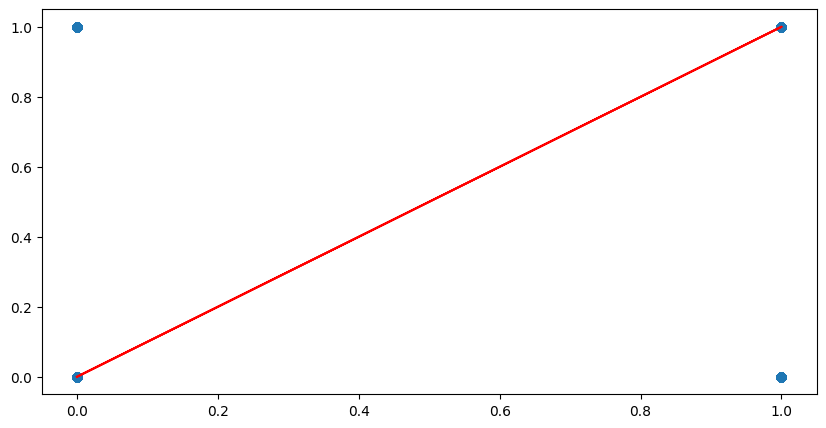

In [16]:
# Visualisation
fig = plt.figure(figsize=(10,5))
plt.scatter(Y_test, y_pred)

# Perfect predictions
plt.plot(Y_test, Y_test,'r')

In [15]:
# Transform x_train and x_test data
X_train_transformed = preprocessor.fit_transform(X_train)
X_validation_transformed = preprocessor.fit_transform(X_validation)
X_test_transformed = preprocessor.fit_transform(X_test)
print(X_train_transformed.shape, X_validation_transformed.shape, X_test_transformed.shape)

(1481915, 101) (185239, 101) (185240, 101)


In [15]:
# Hyperparameter tuning
param_grid = {'n_neighbors': [5, 50, 75, 100]}

knn_model2 = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn_model2, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_validation_transformed, Y_validation)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [5, 50, 75, 100]}, verbose=True)

In [15]:
# Helper function to view grid search results
def report_GridSearchCV_results(gs):
    print("Best combination of hyperparams:\n", gs.best_params_, "\n")
    print("Best mean_test_score score:\n", gs.best_score_, "\n")
    
    scores = []
    for i in range(gs.n_splits_):
        scores.append(gs.cv_results_['split{}_test_score'.format(i)][gs.best_index_])
    print("Score by fold for best estimator:\n", scores, "\n")
    
    # View top 5 hyperparams combinations by mean_test_score (mean on "validation" set)
    print("Top 5 hyperparams combinations by mean_test_score:")
    display(pd.DataFrame(gs.cv_results_)[["rank_test_score", "mean_test_score"] 
                                            + ["param_" + param for param in gs.param_grid]]\
              .sort_values(by = "mean_test_score", ascending = False)\
              .set_index("rank_test_score").head(5))

In [17]:
report_GridSearchCV_results(grid_search)

Best combination of hyperparams:
 {'n_neighbors': 5} 

Best mean_test_score score:
 0.9956650595291314 

Score by fold for best estimator:
 [0.9957082703519758, 0.9954653422586914, 0.9955733103001512, 0.9959511984452603, 0.9956271762895781] 

Top 5 hyperparams combinations by mean_test_score:


,mean_test_score,param_n_neighbors
rank_test_score,,
1,0.995665,5
2,0.995460,50
3,0.995444,75
4,0.995438,100


In [13]:
# Further hyperparameter tuning based on first grid search result
param_grid2 = {'n_neighbors': range(1, 10)}

knn_model3 = KNeighborsClassifier()
grid_search2 = GridSearchCV(estimator=knn_model3, param_grid=param_grid2, cv=5, verbose=True)
grid_search2.fit(X_validation_transformed, Y_validation)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 10)}, verbose=True)

In [16]:
report_GridSearchCV_results(grid_search2)

Best combination of hyperparams:
 {'n_neighbors': 5} 

Best mean_test_score score:
 0.9956650595291314 

Score by fold for best estimator:
 [0.9957082703519758, 0.9954653422586914, 0.9955733103001512, 0.9959511984452603, 0.9956271762895781] 

Top 5 hyperparams combinations by mean_test_score:


,mean_test_score,param_n_neighbors
rank_test_score,,
1,0.995665,5
2,0.995627,3
3,0.995589,7
4,0.995552,4
5,0.995546,9


In [17]:
# Find the best hyperparameter
final_model = grid_search2.best_estimator_
final_model

KNeighborsClassifier()

In [18]:
pipeline_knn2 = Pipeline([("processor", preprocessor), ("knn", KNeighborsClassifier(n_neighbors=5))])

In [19]:
time_start = time.perf_counter()

pipeline_knn2.fit(X_train, Y_train)

training_time = time.perf_counter() - time_start

y_pred2 = pd.Series(pipeline_knn2.predict(X_test))


In [20]:
performance_tracker2 = pd.DataFrame(columns=["Model Name", "Training Time", "Accuracy", "Recall", "Precision", "F1", "ROC AUC"])

In [21]:
performance_tracker2.loc["KNN"] = ["KNN", training_time, accuracy_score(Y_test, y_pred2), recall_score(Y_test, y_pred2), precision_score(Y_test, y_pred2), 
                                  f1_score(Y_test, y_pred2), roc_auc_score(Y_test, y_pred2)]
performance_tracker2

,Model Name,Training Time,Accuracy,Recall,Precision,F1,ROC AUC
KNN,KNN,2.388857,0.996567,0.509298,0.753823,0.607891,0.754212
